In [2]:
import math
import re
import time
from datetime import datetime, date

import requests
from bs4 import BeautifulSoup
from selenium import webdriver

from IPython.display import Image
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

from pykrx import stock
import FinanceDataReader as fdr
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
import FinanceDataReader as fdr
import finterstellar as fs


import talib.abstract as ta
from talib import MA_Type


import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

pd.set_option('max_colwidth', None)
plt.rcParams['font.family']

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


['Malgun Gothic']

# 데이터 로드

In [120]:
import pandas as pd

서울df=pd.read_csv('./datasets/서울2030.csv')
서울df.head(1)

,회원일련번호값,측정일자,측정일련번호,센터명,측정연령수,기존나이구간,추가나이구간,인증구분명,성별구분코드,신장(cm),...,상대악력(%),교차윗몸일으키기(회),왕복오래달리기(회),스텝검사출력(VO₂max),심폐지구력등급,앉아윗몸앞으로굽히기(cm),10M_4회_왕복달리기(초),전신반응(초),제자리멀리뛰기(cm),운동처방내용
0,AAHqSyC0tCo0Z6IOUnO2+tWk,20221006,2,강북,31.0,3.1,3.1,4,0,165.5,...,55.3,43.0,NaN,41.0,3,10.0,NaN,0.377,170.0,앉아서다리밀기


In [121]:
서울df.columns

Index(['회원일련번호값', '측정일자', '측정일련번호', '센터명', '측정연령수', '기존나이구간', '추가나이구간',
       '인증구분명', '성별구분코드', '신장(cm)', '체중(kg)', '체지방율(%)', '허리둘레(cm)',
       'BMI(kg/㎡)', 'BMI_판정', '비만동반질환_위험도', '상대악력(%)', '교차윗몸일으키기(회)',
       '왕복오래달리기(회)', '스텝검사출력(VO₂max)', '심폐지구력등급', '앉아윗몸앞으로굽히기(cm)',
       '10M_4회_왕복달리기(초)', '전신반응(초)', '제자리멀리뛰기(cm)', '운동처방내용'],
      dtype='object')

## 운동처방종합

In [4]:
운동처방종합=pd.read_csv('./datasets/체력측정및운동처방종합데이터.csv')
운동처방종합[['운동처방내용']].head()

,운동처방내용
0,"준비운동:걷기 / 본운동:누워서 전신 뻗기,넙다리 안쪽 스트레칭 / 마무리운동:실내 자전거타기"
1,"본운동:팔굽혀 펴기,팔다리 교차 버티기,손 뻗어 윗몸 일으키기,앉았다 일어서기,앞굽이 앉았다 일어서기,버피 테스트"
2,NaN
3,"준비운동:목 스트레칭,등/어깨 뒤쪽 스트레칭,어깨 뒤쪽 스트레칭,양팔 벌려 전신 비틀기,골반 스트레칭 / 본운동:몸통 들어올리기,벽에서 팔굽혀 펴기,밴드 걸고 누워서 다리 들어올리기,덤벨 잡고 뒤꿈치 들기,짐볼 이용해 앉았다 일어서기,물병 들고 한발 앞으로 내밀고 앉았다 일어서기,짐볼에서 윗몸 일으키기,물통으로 양팔 들어올리기,고정식 트레드밀에서 걷기,고정식 자전거 타기 / 마무리운동:엉덩이 스트레칭,엉덩이 스트레칭2,넙다리 앞쪽 스트레칭,넙다리 안쪽 스트레칭,허리 스트레칭"
4,"준비운동:고정식 트레드밀에서 걷기,고정식 자전거 타기,스텝박스 / 본운동:수영 / 마무리운동:목 스트레칭,등/어깨 뒤쪽 스트레칭,아래 팔 스트레칭,엉덩이 스트레칭,넙다리 앞쪽 스트레칭,넙다리 안쪽 스트레칭,회전근개 스트레칭,어깨 스트레칭"


In [96]:
운동처방종합=운동처방종합[운동처방종합['연령대구분명']=='성인']

In [97]:
운동처방종합['측정연령수'].mode()

0    19.0
Name: 측정연령수, dtype: float64

In [98]:
운동처방종합['측정연령수']=운동처방종합['측정연령수'].fillna(19)

In [99]:
운동처방종합[운동처방종합['측정연령수'].isna()]

,회원일련번호값,측정일련번호,센터명,연령대구분명,측정장소구분명,측정연령수,입력구분명,인증구분명,측정일자,성별구분코드,...,트레드밀_6분(bpm),트레드밀_9분(bpm),트레드밀출력(VO₂max),스텝검사_회복시_심박수(bpm),스텝검사출력(VO₂max),허벅지_좌(cm),허벅지_우(cm),전신반응(초),성인체공시간(초),운동처방내용


In [100]:
ranges=[19,25,30,35,40,45,50,55,60,65]
labels=['20대초반','20대후반','30대초반','30대후반','40대초반','40대후반','50대초반','50대후반','60대초반']
운동처방종합['기존나이구간']=pd.cut(운동처방종합['측정연령수'],ranges,labels=labels)

labels2=['20대초반','20대중반','20대후반','30대초반','30대중반','30대후반','40대초반','40대중반','40대후반','50대초반','50대중반','50대후반','60대초반','60대중반']
ranges2= [19,23,27,30,33,37,40,43,47,50,53,57,60,63,67]
운동처방종합['추가나이구간']=pd.cut(운동처방종합['측정연령수'],ranges2,labels=labels2)

In [101]:
운동처방종합['추가나이구간'].value_counts().sort_index()

20대초반    111500
20대중반     63279
20대후반     32294
30대초반     24562
30대중반     31732
30대후반     24981
40대초반     23509
40대중반     32337
40대후반     26046
50대초반     25567
50대중반     37774
50대후반     32575
60대초반     35279
60대중반     10679
Name: 추가나이구간, dtype: int64

In [108]:
drop_inde=운동처방종합[운동처방종합['측정연령수']==18].index.values
운동처방종합=운동처방종합.drop(drop_inde,axis=0)

In [110]:
운동처방종합['기존나이구간']=운동처방종합['기존나이구간'].fillna('20대초반')
운동처방종합['추가나이구간']=운동처방종합['추가나이구간'].fillna('20대초반')

In [114]:
운동처방종합['운동처방내용']=운동처방종합['운동처방내용'].fillna(운동처방종합['운동처방내용'].mode())

In [115]:
운동처방종합['운동처방내용'].mode()

0    준비운동:유산소 운동 전 동적 루틴 스트레칭 / 본운동:윗몸올리기 ,누워서 엉덩이 ...
Name: 운동처방내용, dtype: object

In [116]:
운동처방종합['운동처방내용']=운동처방종합['운동처방내용'].fillna(method='bfill')

In [117]:
운동처방종합['운동처방내용'].isna().sum()

0

In [119]:
운동처방종합.columns

Index(['회원일련번호값', '측정일련번호', '센터명', '연령대구분명', '측정장소구분명', '측정연령수', '입력구분명',
       '인증구분명', '측정일자', '성별구분코드', '신장(cm)', '체중(kg)', '체지방율(%)', '허리둘레(cm)',
       '이완기최저혈압(mmHg)', '수축기최고혈압(mmHg)', '악력_좌(kg)', '악력_우(kg)', '윗몸말아올리기(회)',
       '반복점프(회)', '앉아윗몸앞으로굽히기(cm)', '일리노이(초)', '체공시간(초)', '협응력시간(초)',
       '협응력실수횟수(회)', '협응력계산결과값(초)', 'BMI(kg/㎡)', '교차윗몸일으키기(회)', '왕복오래달리기(회)',
       '10M_4회_왕복달리기(초)', '제자리멀리뛰기(cm)', '의자에앉았다일어서기(회)', '6분걷기(m)',
       '2분제자리걷기(회)', ' 의자에앉아_3M표적_돌아오기(초)', '8자보행(초)', '상대악력(%)', '피부두겹합',
       '왕복오래달리기출력(VO₂max)', '트레드밀_안정시(bpm)', '트레드밀_3분(bpm)', '트레드밀_6분(bpm)',
       '트레드밀_9분(bpm)', '트레드밀출력(VO₂max)', '스텝검사_회복시_심박수(bpm)', '스텝검사출력(VO₂max)',
       '허벅지_좌(cm)', '허벅지_우(cm)', '전신반응(초)', '성인체공시간(초)', '운동처방내용', '기존나이구간',
       '추가나이구간'],
      dtype='object')

In [ ]:
[['회원일련번호값', '측정일자', '측정일련번호', '센터명', '측정연령수','기존나이구간', '추가나이구간',
       '인증구분명', '성별구분코드', '신장(cm)', '체중(kg)', '체지방율(%)', '허리둘레(cm)',
       'BMI(kg/㎡)',  '상대악력(%)', '교차윗몸일으키기(회)',
       '왕복오래달리기(회)', '스텝검사출력(VO₂max)', '트레드밀출력(VO₂max)', '앉아윗몸앞으로굽히기(cm)',
       '10M_4회_왕복달리기(초)', '전신반응(초)', '제자리멀리뛰기(cm)','성인체공시간(초)', '운동처방내용']]

In [118]:
운동처방종합.isna().sum()

회원일련번호값                     0
측정일련번호                      0
센터명                         0
연령대구분명                      0
측정장소구분명                     0
측정연령수                       0
입력구분명                       0
인증구분명                       1
측정일자                        0
성별구분코드                      0
신장(cm)                     43
체중(kg)                     29
체지방율(%)                   716
허리둘레(cm)               220899
이완기최저혈압(mmHg)             107
수축기최고혈압(mmHg)             114
악력_좌(kg)                 1115
악력_우(kg)                 1043
윗몸말아올리기(회)             571192
반복점프(회)                571192
앉아윗몸앞으로굽히기(cm)           2228
일리노이(초)                571192
체공시간(초)                571192
협응력시간(초)               571192
협응력실수횟수(회)             571192
협응력계산결과값(초)            571192
BMI(kg/㎡)                  16
교차윗몸일으키기(회)              6207
왕복오래달리기(회)             301120
10M_4회_왕복달리기(초)        220145
제자리멀리뛰기(cm)             44190
의자에앉았다일어서기(회)          571192
6분걷기(m)                571192
2분제자리걷기(회)

In [112]:
운동처방종합[['측정연령수']][운동처방종합['추가나이구간'].isna()].value_counts()

Series([], dtype: int64)

In [27]:
type(운동처방종합['기존나이구간'].values)

pandas.core.arrays.categorical.Categorical

In [32]:
운동처방종합=운동처방종합[['회원일련번호값', '측정일자', '측정일련번호', '센터명', '측정연령수','기존나이구간', '추가나이구간',
       '인증구분명', '성별구분코드', '신장(cm)', '체중(kg)', '체지방율(%)', '허리둘레(cm)',
       'BMI(kg/㎡)',  '상대악력(%)', '교차윗몸일으키기(회)',
       '왕복오래달리기(회)', '스텝검사출력(VO₂max)',  '앉아윗몸앞으로굽히기(cm)',
       '10M_4회_왕복달리기(초)', '전신반응(초)', '제자리멀리뛰기(cm)', '운동처방내용']]

In [37]:
운동처방종합.columns

Index(['회원일련번호값', '측정일자', '측정일련번호', '센터명', '측정연령수', '기존나이구간', '추가나이구간',
       '인증구분명', '성별구분코드', '신장(cm)', '체중(kg)', '체지방율(%)', '허리둘레(cm)',
       'BMI(kg/㎡)', '상대악력(%)', '교차윗몸일으키기(회)', '왕복오래달리기(회)', '스텝검사출력(VO₂max)',
       '앉아윗몸앞으로굽히기(cm)', '10M_4회_왕복달리기(초)', '전신반응(초)', '제자리멀리뛰기(cm)',
       '운동처방내용'],
      dtype='object')

In [87]:
운동처방종합.isna().sum()

회원일련번호값                 0
측정일자                    0
측정일련번호                  0
센터명                     0
측정연령수                   6
기존나이구간              59081
추가나이구간              59081
인증구분명                   1
성별구분코드                  0
신장(cm)                 43
체중(kg)                 29
체지방율(%)               716
허리둘레(cm)           220901
BMI(kg/㎡)              16
상대악력(%)               666
교차윗몸일으키기(회)          6207
왕복오래달리기(회)         301120
스텝검사출력(VO₂max)     336251
앉아윗몸앞으로굽히기(cm)       2228
10M_4회_왕복달리기(초)    220145
전신반응(초)            370785
제자리멀리뛰기(cm)         44190
준비운동                    0
본운동                     0
마무리운동                   0
dtype: int64

,회원일련번호값,측정일자,측정일련번호,센터명,측정연령수,기존나이구간,추가나이구간,인증구분명,성별구분코드,신장(cm),...,교차윗몸일으키기(회),왕복오래달리기(회),스텝검사출력(VO₂max),앉아윗몸앞으로굽히기(cm),10M_4회_왕복달리기(초),전신반응(초),제자리멀리뛰기(cm),준비운동,본운동,마무리운동
873114,AAE3AzHZ/qbXown+SpTpSMTo,20210111,2,KSPO아산(출장),NaN,NaN,NaN,참가증,M,149.8,...,24.0,NaN,NaN,22.6,NaN,0.376,136.0,"실내자전거타기,트레드밀에서걷기,수영","준비운동:실내자전거타기,트레드밀에서걷기,수영","준비운동:실내자전거타기,트레드밀에서걷기,수영"
874271,AAHbVJZR+6x3E8LeuHtoYt+O,20210127,2,강북,NaN,NaN,NaN,참가증,M,167.9,...,45.0,NaN,NaN,8.6,NaN,0.324,200.0,"팔굽혀펴기,앉았다일어서기,윗몸올리기,누워서엉덩이들어올리기,한발앞으로내밀고앉았다일어서...","준비운동:팔굽혀펴기,앉았다일어서기,윗몸올리기,누워서엉덩이들어올리기,한발앞으로내밀고앉...","준비운동:팔굽혀펴기,앉았다일어서기,윗몸올리기,누워서엉덩이들어올리기,한발앞으로내밀고앉..."
875371,AAEntn8/YlloOXXU046tThO/,20210205,1,강북,NaN,NaN,NaN,참가증,M,172.9,...,26.0,NaN,NaN,14.8,NaN,0.369,158.0,"팔굽혀펴기,앉았다일어서기,윗몸올리기,누워서엉덩이들어올리기,한발앞으로내밀고앉았다일어서...","준비운동:팔굽혀펴기,앉았다일어서기,윗몸올리기,누워서엉덩이들어올리기,한발앞으로내밀고앉...","준비운동:팔굽혀펴기,앉았다일어서기,윗몸올리기,누워서엉덩이들어올리기,한발앞으로내밀고앉..."
876058,AAGnwwNyNDjjvxYNk1iz63OQ,20210216,1,강북,NaN,NaN,NaN,참가증,M,166.5,...,44.0,NaN,41.3,18.5,NaN,0.326,214.0,"팔굽혀펴기,벽에서팔굽혀펴기,앉았다일어서기,윗몸올리기,누워서엉덩이들어올리기,한발앞으로...","준비운동:팔굽혀펴기,벽에서팔굽혀펴기,앉았다일어서기,윗몸올리기,누워서엉덩이들어올리기,...","준비운동:팔굽혀펴기,벽에서팔굽혀펴기,앉았다일어서기,윗몸올리기,누워서엉덩이들어올리기,..."
876583,AAHqHcY0mDtB1ft21p221Ny2,20210219,1,강북,NaN,NaN,NaN,참가증,M,168.7,...,36.0,NaN,NaN,15.4,NaN,0.358,156.0,"스텝퍼옆으로뛰어넘기,앉았다일어서면서점프하기,버피운동,바벨들어올리기,앉았다일어서기,윗...","준비운동:스텝퍼옆으로뛰어넘기,앉았다일어서면서점프하기,버피운동,바벨들어올리기,앉았다일...","준비운동:스텝퍼옆으로뛰어넘기,앉았다일어서면서점프하기,버피운동,바벨들어올리기,앉았다일..."
878858,AAGQc1fK+YYCAGLXsDkpq3eh,20210305,1,천안,NaN,NaN,NaN,참가증,M,150.2,...,49.0,NaN,NaN,26.2,NaN,0.334,199.0,"어깨뒤쪽스트레칭,요통을위한스트레칭1,하지루틴스트레칭2","준비운동:어깨뒤쪽스트레칭,요통을위한스트레칭1,하지루틴스트레칭2","준비운동:어깨뒤쪽스트레칭,요통을위한스트레칭1,하지루틴스트레칭2"


In [31]:
# 운동처방종합['기존나이구간'].transform(lambda x :x.replace(['(19, 25]','(25, 30]','(30, 35]','(35, 40]','(40, 45]','(45, 50]','(50, 55]','(55, 60]','(60, 65]'],
#                                                ['20대초반','20대후반','30대초반','30대후반','40대초반','40대후반','50대초반','50대후반','60대초반']))

## 서울만

In [123]:
서울센터 = ['강북', '강동', '서대문', '중구(서울)', 'KSPO송파(출장B)', '동작','KSPO송파(출장A)', '마포',  'KSPO송파(출장)', 'KSPO송파', '성동', '서초', '노원', '금천', 'KSPO건강체력']
서울df_list=[]
for name in 서울센터:
    temp=운동처방종합[운동처방종합['센터명']==name]
    서울df_list.append(temp)

In [124]:
서울=pd.concat(서울df_list)
서울.shape

(240087, 51)

In [125]:
서울.columns

Index(['회원일련번호값', '측정일련번호', '센터명', '연령대구분명', '측정장소구분명', '측정연령수', '입력구분명',
       '인증구분명', '측정일자', '성별구분코드', '신장(cm)', '체중(kg)', '체지방율(%)', '허리둘레(cm)',
       '이완기최저혈압(mmHg)', '수축기최고혈압(mmHg)', '악력_좌(kg)', '악력_우(kg)', '윗몸말아올리기(회)',
       '반복점프(회)', '앉아윗몸앞으로굽히기(cm)', '일리노이(초)', '체공시간(초)', '협응력시간(초)',
       '협응력실수횟수(회)', '협응력계산결과값(초)', 'BMI(kg/㎡)', '교차윗몸일으키기(회)', '왕복오래달리기(회)',
       '10M_4회_왕복달리기(초)', '제자리멀리뛰기(cm)', '의자에앉았다일어서기(회)', '6분걷기(m)',
       '2분제자리걷기(회)', ' 의자에앉아_3M표적_돌아오기(초)', '8자보행(초)', '상대악력(%)', '피부두겹합',
       '왕복오래달리기출력(VO₂max)', '트레드밀_안정시(bpm)', '트레드밀_3분(bpm)', '트레드밀_6분(bpm)',
       '트레드밀_9분(bpm)', '트레드밀출력(VO₂max)', '스텝검사_회복시_심박수(bpm)', '스텝검사출력(VO₂max)',
       '허벅지_좌(cm)', '허벅지_우(cm)', '전신반응(초)', '성인체공시간(초)', '운동처방내용'],
      dtype='object')

# merge

In [126]:
total_seoul=pd.merge(서울df,서울[['회원일련번호값','운동처방내용']],on='회원일련번호값')
total_seoul.head(1)

,회원일련번호값,측정일자,측정일련번호,센터명,측정연령수,기존나이구간,추가나이구간,인증구분명,성별구분코드,신장(cm),...,교차윗몸일으키기(회),왕복오래달리기(회),스텝검사출력(VO₂max),심폐지구력등급,앉아윗몸앞으로굽히기(cm),10M_4회_왕복달리기(초),전신반응(초),제자리멀리뛰기(cm),운동처방내용_x,운동처방내용_y
0,AAHqSyC0tCo0Z6IOUnO2+tWk,20221006,2,강북,31.0,3.1,3.1,4,0,165.5,...,43.0,NaN,41.0,3,10.0,NaN,0.377,170.0,앉아서다리밀기,"준비운동:상지 루틴 스트레칭,하지 루틴 스트레칭1,엎드려 버티기,앉았다 일어서기,누..."


In [127]:
total_seoul=total_seoul.drop('운동처방내용_x',axis=1)
total_seoul.head(1)

,회원일련번호값,측정일자,측정일련번호,센터명,측정연령수,기존나이구간,추가나이구간,인증구분명,성별구분코드,신장(cm),...,상대악력(%),교차윗몸일으키기(회),왕복오래달리기(회),스텝검사출력(VO₂max),심폐지구력등급,앉아윗몸앞으로굽히기(cm),10M_4회_왕복달리기(초),전신반응(초),제자리멀리뛰기(cm),운동처방내용_y
0,AAHqSyC0tCo0Z6IOUnO2+tWk,20221006,2,강북,31.0,3.1,3.1,4,0,165.5,...,55.3,43.0,NaN,41.0,3,10.0,NaN,0.377,170.0,"준비운동:상지 루틴 스트레칭,하지 루틴 스트레칭1,엎드려 버티기,앉았다 일어서기,누..."


In [15]:
total_seoul.shape

(745032, 26)

In [128]:
total_seoul=total_seoul.rename(columns={'운동처방내용_y':'운동처방내용'})

In [140]:
mode_var=total_seoul['운동처방내용'].mode()[0]
total_seoul['운동처방내용']=total_seoul['운동처방내용'].fillna(mode_var)

In [142]:
# total_seoul[total_seoul['운동처방내용']==mode_var]

In [10]:
# drop_idx=total_seoul[total_seoul['운동처방내용'].isna()].index.values
# total_seoul=total_seoul.drop(drop_idx,axis=0)

# 워드클라우드

In [143]:
listlist=[]
for i in range(len(total_seoul)):
    split_list=total_seoul['운동처방내용'].iloc[i].split(' / ')
    aaa= total_seoul['성별구분코드'].iloc[i]
    aa= total_seoul['측정연령수'].iloc[i]
    a=total_seoul['기존나이구간'].iloc[i]
    b= total_seoul['추가나이구간'].iloc[i]
    c=total_seoul['인증구분명'].iloc[i]
    if len(split_list)>=3:
        listlist.append([aaa,aa,a,b,c,split_list[0],split_list[1],split_list[2]])
    if len(split_list)<3:
        listlist.append([aaa,aa,a,b,c,split_list[0],split_list[0],split_list[0]])

In [68]:
listlist2=[]
for i in range(len(운동처방종합)):
    split_list2=운동처방종합['운동처방내용'].iloc[i].split(' / ')
    aaa2= 운동처방종합['성별구분코드'].iloc[i]
    aa2= 운동처방종합['측정연령수'].iloc[i]
    a2=운동처방종합['기존나이구간'].iloc[i]
    b2= 운동처방종합['추가나이구간'].iloc[i]
    c2=운동처방종합['인증구분명'].iloc[i]
    if len(split_list2)>=3:
        listlist2.append([aaa2,aa2,a2,b2,c2,split_list2[0],split_list2[1],split_list2[2]])
    elif len(split_list2)<3:
        listlist2.append([aaa2,aa2,a2,b2,c2,split_list2[0],split_list2[0],split_list2[0]])

In [70]:
import pandas as pd
워드클라우드용2=pd.DataFrame(listlist2,columns=['성별구분코드','측정연령수','기존나이구간','추가나이구간','인증구분명','준비운동','본운동','마무리운동'])
워드클라우드용2.shape

(571195, 8)

In [144]:
import pandas as pd
워드클라우드용=pd.DataFrame(listlist,columns=['성별구분코드','측정연령수','기존나이구간','추가나이구간','인증구분명','준비운동','본운동','마무리운동'])
워드클라우드용.head()

,성별구분코드,측정연령수,기존나이구간,추가나이구간,인증구분명,준비운동,본운동,마무리운동
0,0,31.0,3.1,3.1,4,"준비운동:상지 루틴 스트레칭,하지 루틴 스트레칭1,엎드려 버티기,앉았다 일어서기,누워서 엉덩이 들어올리기,허리 스트레칭,팔굽혀 펴기,버피 테스트,네발기기 자세에서 손바닥으로 바닥밀기,아령 뒤로 들어올리기","준비운동:상지 루틴 스트레칭,하지 루틴 스트레칭1,엎드려 버티기,앉았다 일어서기,누워서 엉덩이 들어올리기,허리 스트레칭,팔굽혀 펴기,버피 테스트,네발기기 자세에서 손바닥으로 바닥밀기,아령 뒤로 들어올리기","준비운동:상지 루틴 스트레칭,하지 루틴 스트레칭1,엎드려 버티기,앉았다 일어서기,누워서 엉덩이 들어올리기,허리 스트레칭,팔굽혀 펴기,버피 테스트,네발기기 자세에서 손바닥으로 바닥밀기,아령 뒤로 들어올리기"
1,0,31.0,3.1,3.1,4,"준비운동:유산소 운동 전 동적 루틴 스트레칭,하지 루틴 스트레칭1,상지 루틴 스트레칭,좌식생활자를 위한 동적 루틴 스트레칭","본운동:앉아서 다리 밀기,앉아서 다리 펴기,앉아서 다리 굽히기,누워서 밀기,앉아서 모으기,앉아서 위로 밀기,바벨들어올리기,앉았다 일어서기,한발 앞으로 내밀고 앉았다 일어서기,턱걸이,바벨 끌어당기기,허리 굽혀 덤벨 들기,누워서 덤벨 들어올리기,손목 펴기/굽히기,소파를 이용한 윗몸올리기,누워서 다리 들어올리기,누워서 하늘 자전거,누워서 엉덩이 들어올리기,팔굽혀펴기,달리기,실내 자전거타기,계단 올라갔다 내려오기,계단 뛰어 오르기,수영","마무리운동:목 스트레칭,등/어깨 뒤쪽 스트레칭,아래 팔 스트레칭,허리 스트레칭,배스트레칭,엉덩이 스트레칭,넙다리 뒤쪽 스트레칭,넙다리 안쪽 스트레칭,하지 루틴 스트레칭2"
2,0,31.0,3.1,3.1,4,"준비운동:상지 루틴 스트레칭,하지 루틴 스트레칭1,엎드려 버티기,앉았다 일어서기,누워서 엉덩이 들어올리기,허리 스트레칭,팔굽혀 펴기,버피 테스트,네발기기 자세에서 손바닥으로 바닥밀기,아령 뒤로 들어올리기","준비운동:상지 루틴 스트레칭,하지 루틴 스트레칭1,엎드려 버티기,앉았다 일어서기,누워서 엉덩이 들어올리기,허리 스트레칭,팔굽혀 펴기,버피 테스트,네발기기 자세에서 손바닥으로 바닥밀기,아령 뒤로 들어올리기","준비운동:상지 루틴 스트레칭,하지 루틴 스트레칭1,엎드려 버티기,앉았다 일어서기,누워서 엉덩이 들어올리기,허리 스트레칭,팔굽혀 펴기,버피 테스트,네발기기 자세에서 손바닥으로 바닥밀기,아령 뒤로 들어올리기"
3,0,31.0,3.1,3.1,4,"준비운동:유산소 운동 전 동적 루틴 스트레칭,하지 루틴 스트레칭1,상지 루틴 스트레칭,좌식생활자를 위한 동적 루틴 스트레칭","본운동:앉아서 다리 밀기,앉아서 다리 펴기,앉아서 다리 굽히기,누워서 밀기,앉아서 모으기,앉아서 위로 밀기,바벨들어올리기,앉았다 일어서기,한발 앞으로 내밀고 앉았다 일어서기,턱걸이,바벨 끌어당기기,허리 굽혀 덤벨 들기,누워서 덤벨 들어올리기,손목 펴기/굽히기,소파를 이용한 윗몸올리기,누워서 다리 들어올리기,누워서 하늘 자전거,누워서 엉덩이 들어올리기,팔굽혀펴기,달리기,실내 자전거타기,계단 올라갔다 내려오기,계단 뛰어 오르기,수영","마무리운동:목 스트레칭,등/어깨 뒤쪽 스트레칭,아래 팔 스트레칭,허리 스트레칭,배스트레칭,엉덩이 스트레칭,넙다리 뒤쪽 스트레칭,넙다리 안쪽 스트레칭,하지 루틴 스트레칭2"
4,0,26.0,2.3,2.2,4,"준비운동:상지 루틴 스트레칭,하지 루틴 스트레칭1,엎드려 버티기,앉았다 일어서기,누워서 엉덩이 들어올리기,허리 스트레칭,팔굽혀 펴기,버피 테스트,네발기기 자세에서 손바닥으로 바닥밀기,아령 뒤로 들어올리기","준비운동:상지 루틴 스트레칭,하지 루틴 스트레칭1,엎드려 버티기,앉았다 일어서기,누워서 엉덩이 들어올리기,허리 스트레칭,팔굽혀 펴기,버피 테스트,네발기기 자세에서 손바닥으로 바닥밀기,아령 뒤로 들어올리기","준비운동:상지 루틴 스트레칭,하지 루틴 스트레칭1,엎드려 버티기,앉았다 일어서기,누워서 엉덩이 들어올리기,허리 스트레칭,팔굽혀 펴기,버피 테스트,네발기기 자세에서 손바닥으로 바닥밀기,아령 뒤로 들어올리기"


In [145]:
워드클라우드용['준비운동']=워드클라우드용['준비운동'].transform(lambda x : x.replace('준비운동:',''))
워드클라우드용['본운동']=워드클라우드용['본운동'].transform(lambda x : x.replace('본운동:',''))
워드클라우드용['마무리운동']=워드클라우드용['마무리운동'].transform(lambda x : x.replace('마무리운동:',''))


In [162]:
total_seoul['마무리운동'].value_counts()

목스트레칭,등/어깨뒤쪽스트레칭,가슴/어깨앞쪽스트레칭,허리스트레칭,배스트레칭,넙다리뒤쪽스트레칭,넙다리앞쪽스트레칭,넙다리안쪽스트레칭                                          184716
폼롤러이용유연성운동루틴프로그램,의자이용유연성운동루틴프로그램                                                                                  46952
서서발목뒤로당기기,전신루틴스트레칭,하지루틴스트레칭2                                                                                      42172
준비운동:목스트레칭,유산소운동전동적루틴스트레칭                                                                                         36153
배스트레칭,넙다리뒤쪽스트레칭,넙다리앞쪽스트레칭,넙다리안쪽스트레칭                                                                               34456
                                                                                                                  ...  
본운동:누워서배가로근수축I,윗몸일으키기,크런치사이클,누워서다리들어올리기,누워서수직으로다리들어올리기,앉아서다리펴서들어올리기,네발기기자세로팔다리들기,발바꿔뛰기,매달려서다리들기,전완대고버티기,배스트레칭         1
본운동:조깅,달리기,계단오르기,실내자전거타기,수영,아쿠아로빅                                                                                     1
본운동:다리모았다벌려뛰기,엎드려무릎연속차기,계단뛰어오르기,수영,스텝박스오

In [14]:
워드클라우드용.shape

(504388, 8)

In [146]:
워드클라우드용['준비운동']=워드클라우드용['준비운동'].transform(lambda x : x.replace(' ',''))
워드클라우드용['본운동']=워드클라우드용['본운동'].transform(lambda x : x.replace(' ',''))
워드클라우드용['마무리운동']=워드클라우드용['마무리운동'].transform(lambda x : x.replace(' ',''))

In [72]:
워드클라우드용2['준비운동']=워드클라우드용2['준비운동'].transform(lambda x : x.replace(' ',''))
워드클라우드용2['본운동']=워드클라우드용2['본운동'].transform(lambda x : x.replace(' ',''))
워드클라우드용2['마무리운동']=워드클라우드용2['마무리운동'].transform(lambda x : x.replace(' ',''))

In [18]:
워드클라우드용['마무리운동'][0][6:]

'목스트레칭,등/어깨뒤쪽스트레칭,아래팔스트레칭,허리스트레칭,배스트레칭,엉덩이스트레칭,넙다리뒤쪽스트레칭,넙다리안쪽스트레칭,하지루틴스트레칭2'

In [ ]:
# for i in range(len(total_seoul)):
#     워드클라우드용['준비운동'].iloc[i]=워드클라우드용['준비운동'].iloc[i][5:]
#     워드클라우드용['본운동'].iloc[i]=워드클라우드용['본운동'].iloc[i][4:]
#     워드클라우드용['마무리운동'].iloc[i]=워드클라우드용['마무리운동'].iloc[i][6:]

In [147]:
total_seoul['준비운동']=워드클라우드용['준비운동'].values
total_seoul['본운동']=워드클라우드용['본운동'].values
total_seoul['마무리운동']=워드클라우드용['마무리운동'].values

In [148]:
total_seoul=total_seoul.drop('운동처방내용',axis=1)
total_seoul.head(1)

,회원일련번호값,측정일자,측정일련번호,센터명,측정연령수,기존나이구간,추가나이구간,인증구분명,성별구분코드,신장(cm),체중(kg),체지방율(%),허리둘레(cm),BMI(kg/㎡),BMI_판정,비만동반질환_위험도,상대악력(%),교차윗몸일으키기(회),왕복오래달리기(회),스텝검사출력(VO₂max),심폐지구력등급,앉아윗몸앞으로굽히기(cm),10M_4회_왕복달리기(초),전신반응(초),제자리멀리뛰기(cm),준비운동,본운동,마무리운동
0,AAHqSyC0tCo0Z6IOUnO2+tWk,20221006,2,강북,31.0,3.1,3.1,4,0,165.5,76.7,34.6,96.0,28.0,3,4,55.3,43.0,NaN,41.0,3,10.0,NaN,0.377,170.0,"상지루틴스트레칭,하지루틴스트레칭1,엎드려버티기,앉았다일어서기,누워서엉덩이들어올리기,허리스트레칭,팔굽혀펴기,버피테스트,네발기기자세에서손바닥으로바닥밀기,아령뒤로들어올리기","준비운동:상지루틴스트레칭,하지루틴스트레칭1,엎드려버티기,앉았다일어서기,누워서엉덩이들어올리기,허리스트레칭,팔굽혀펴기,버피테스트,네발기기자세에서손바닥으로바닥밀기,아령뒤로들어올리기","준비운동:상지루틴스트레칭,하지루틴스트레칭1,엎드려버티기,앉았다일어서기,누워서엉덩이들어올리기,허리스트레칭,팔굽혀펴기,버피테스트,네발기기자세에서손바닥으로바닥밀기,아령뒤로들어올리기"


In [176]:
total_seoul[['준비운동','본운동','마무리운동']]=total_seoul[['준비운동','본운동','마무리운동']].transform(lambda x : x.replace(['준비운동:','본운동:','마무리운동:'],['','','']))
# total_seoul['본운동']=total_seoul['본운동'].transform(lambda x : x.replace('본운동:',''))
# total_seoul['마무리운동']=total_seoul['마무리운동'].transform(lambda x : x.replace('마무리운동:',''))

In [183]:
total_seoul['본운동']=total_seoul['본운동'].transform(lambda x : x.replace('준비운동:',''))

In [186]:
total_seoul['준비운동']=total_seoul['준비운동'].transform(lambda x : x.replace('본운동:',''))

In [189]:
total_seoul['마무리운동']=total_seoul['마무리운동'].transform(lambda x : x.replace('본운동:',''))

In [194]:
total_seoul['마무리운동']=total_seoul['마무리운동'].transform(lambda x : x.replace('준비운동:',''))

In [190]:
total_seoul['마무리운동'].value_counts()

목스트레칭,등/어깨뒤쪽스트레칭,가슴/어깨앞쪽스트레칭,허리스트레칭,배스트레칭,넙다리뒤쪽스트레칭,넙다리앞쪽스트레칭,넙다리안쪽스트레칭    184716
폼롤러이용유연성운동루틴프로그램,의자이용유연성운동루틴프로그램                                            46952
서서발목뒤로당기기,전신루틴스트레칭,하지루틴스트레칭2                                                42172
준비운동:목스트레칭,유산소운동전동적루틴스트레칭                                                   36153
배스트레칭,넙다리뒤쪽스트레칭,넙다리앞쪽스트레칭,넙다리안쪽스트레칭                                         34456
                                                                            ...  
윗몸말아올리기,팔굽혀펴기,앉았다일어서기,슈퍼맨자세,엎드려팔대고버티기,엎드려무릎당기기,다리앞뒤로벌려굽혔다펴기,엎드려팔로걷기             1
누워서배가로근수축I,윗몸일으키기,크런치사이클,누워서다리들어올리기,누워서수직으로다리들어올리기,앉아서다리펴서들어올리기                 1
앉았다일어서기,바벨잡고들어올리기,몸통들어올리기,팔굽혀펴기,서서바벨위로밀기,덤벨옆으로들어올리기,윗몸올리기,전완대고버티기               1
윗몸일으키기,크런치사이클,누워서다리들어올리기,누워서수직으로다리들어올리기,전완대고버티기                                 1
걷기,조깅,전신루틴스트레칭                                                                  1
Name: 마무리운동, Length: 3012, dtype: int64

In [152]:
total_seoul.isna().sum()

회원일련번호값                 0
측정일자                    0
측정일련번호                  0
센터명                     0
측정연령수                   0
기존나이구간                  0
추가나이구간                  0
인증구분명                   0
성별구분코드                  0
신장(cm)                329
체중(kg)                181
체지방율(%)               293
허리둘레(cm)                0
BMI(kg/㎡)               0
BMI_판정                  0
비만동반질환_위험도              0
상대악력(%)               223
교차윗몸일으키기(회)          1780
왕복오래달리기(회)         598155
스텝검사출력(VO₂max)          0
심폐지구력등급                 0
앉아윗몸앞으로굽히기(cm)       1136
10M_4회_왕복달리기(초)    350740
전신반응(초)            612511
제자리멀리뛰기(cm)         96946
준비운동                    0
본운동                     0
마무리운동                   0
dtype: int64

In [79]:
# 운동처방종합.to_csv('datasets/운동처방종합.csv',index=False)

In [69]:
# pd.merge(운동처방종합,워드클라우드용2[['측정연령수','준비운동','본운동','마무리운동']],on='측정연령수').head()


<b> 경우의 수 </b>
<pre>
성별      나이       등급
남      20대초반     1등급
여      20대후반     2등급
        30대초반     3등급
        30대후반     4등급


<pre>
남20_1 남20중_1 남20후_1 여20_1 여20중_1 여20후_1
남20_2 남20중_2 남20후_2 여20_2 여20중_2 여20후_2
남20_3 남20중_3 남20후_3 여20_3 여20중_3 여20후_3
남20_4 남20중_4 남20후_4 여20_4 여20중_4 여20후_4

남30_1 남30중_1 남30후_1 여30_1 여30중_1 여30후_1
남30_2 남30중_2 남30후_2 여30_2 여30중_2 여30후_2
남30_3 남30중_3 남30후_3 여30_3 여30중_3 여30후_3
남30_4 남30중_4 남30후_4 여30_4 여30중_4 여30후_4

In [21]:
# 워드클라우드용[(워드클라우드용['성별구분코드']==1)&(워드클라우드용['추가나이구간']==3.2)&(워드클라우드용['인증구분명']==4)]

In [ ]:
np.arange(19,40)

In [154]:
total_seoul['추가나이구간']=total_seoul['추가나이구간'].transform(lambda x : x.replace([2.1,2.2,2.3,3.1,3.2,3.3],['20대초반','20대중반','20대후반','30대초반','30대중반','30대후반']))
total_seoul['기존나이구간']=total_seoul['기존나이구간'].transform(lambda x : x.replace([2.1,2.3,3.1,3.3],['20대초반','20대후반','30대초반','30대후반']))
total_seoul['성별구분코드']=total_seoul['성별구분코드'].transform(lambda x : x.replace([0,1],['남','여']))

In [157]:
total_seoul['성별구분코드'].value_counts().index.values

array(['남', '여'], dtype=object)

In [195]:
# total_seoul.to_csv('./datasets/total_seoul.csv',index=False)

In [ ]:
import pandas as pd
워드클라우드용=pd.read_csv('./datasets/워드클라우드용df.csv')

## 성별 / 각 나이 / 인증등급

In [ ]:
성별_list=['남','여']
나이_list=np.arange(19,40)
인증등급_list=[1,2,3,4]

for sex in 성별_list:
    for age in 나이_list:
        for grade in 인증등급_list:
            globals()[str(sex) + '_' + str(age)+ '_' + str(grade)]=워드클라우드용[(워드클라우드용['성별구분코드']==sex)&(워드클라우드용['측정연령']==age)&(워드클라우드용['인증구분명']==grade)]
    

In [ ]:
# 남_21_3

## 성별 / 추가나이구간 / 인증등급

In [ ]:
성별_list=['남','여']
추가나이구간_list=['20대초반','20대중반','20대후반','30대초반','30대중반','30대후반']
인증등급_list=[1,2,3,4]

for sex in 성별_list:
    for age in 추가나이구간_list:
        for grade in 인증등급_list:
            globals()[str(age)+ '_' + str(age)+ '_'+'추가'+ '_' + str(grade)]=워드클라우드용[(워드클라우드용['성별구분코드']==sex)&(워드클라우드용['추가나이구간']==age)&(워드클라우드용['인증구분명']==grade)]

In [ ]:
# 여_20대초반_추가_2

## 성별 / 기존나이구간 / 인증등급

In [ ]:
성별_list=['남','여']
추가나이구간_list=['20대초반','20대후반','30대초반','30대후반']
인증등급_list=[1,2,3,4]

for sex in 성별_list:
    for age in 추가나이구간_list:
        for grade in 인증등급_list:
            globals()[str(sex) + '_' + str(age)+ '_'+'기존' + str(grade)]=워드클라우드용[(워드클라우드용['성별구분코드']==sex)&(워드클라우드용['기존나이구간']==age)&(워드클라우드용['인증구분명']==grade)]

In [ ]:
# 여_30대후반_기존_3

In [ ]:
# from nltk.tokenize import word_tokenize
# a_list=[]
# b_list=[]
# c_list=[]

# for i in range(len(남20_1)):
#     sent =남20_1['준비운동'].values[i]
#     sent1 =남20_1['본운동'].values[i]
#     sent2 =남20_1['마무리운동'].values[i]
#     token=word_tokenize(sent)
#     token1=word_tokenize(sent1)
#     token2=word_tokenize(sent2)
#     a_list.extend(token)
#     b_list.extend(token1)
#     c_list.extend(token2)

In [ ]:
# fig = plt.figure()
# rows = 1
# cols = 3
# ax1 = fig.add_subplot(rows, cols, 1)
# ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
# ax1.set_title('Jumok community')
# ax1.axis("off")
 
# ax2 = fig.add_subplot(rows, cols, 2)
# ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
# ax2.set_title('Withered trees')
# ax2.axis("off")

# ax3 = fig.add_subplot(rows, cols, 3)
# ax3.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
# ax3.set_title('Withered trees')
# ax3.axis("off")
 
# plt.show()

<b> 컬러맵 </b>

<pre>
'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'


In [196]:
from keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud
def word_cloud_def(df_list): 
    for df in df_list:
        운동_list=[df['준비운동'],df['본운동'],df['마무리운동']]
        gen_list=[]
        for data in 운동_list:
            token = Tokenizer()
            token.fit_on_texts(data)
            wc = WordCloud(font_path='malgun', background_color="white", max_font_size=60,colormap = 'Set3')
            gen = wc.generate_from_frequencies(token.word_docs)
            gen_list.append(gen)
    
        fig,ax = plt.subplots(1,3, figsize=(10,5))
        fig.tight_layout()
        
        ax[0].imshow(gen_list[0])
        ax[0].set_title("준비운동")
        
        ax[1].imshow(gen_list[1])
        ax[1].set_title("본운동")
        
        ax[2].imshow(gen_list[2])
        ax[2].set_title("마무리운동")
        
        plt.figure()

def make_df_list(sex,age):
    df_list=[]
    for i in range(1, 5):
        temp=total_seoul[(total_seoul['성별구분코드']==sex)&(total_seoul['측정연령수']==age)&(total_seoul['인증구분명']==i)]
        df_list.append(temp)
    graph=word_cloud_def(df_list)
    return graph

당신의 성별은? : 남
당신의 나이는(19-39) ? : 34


None


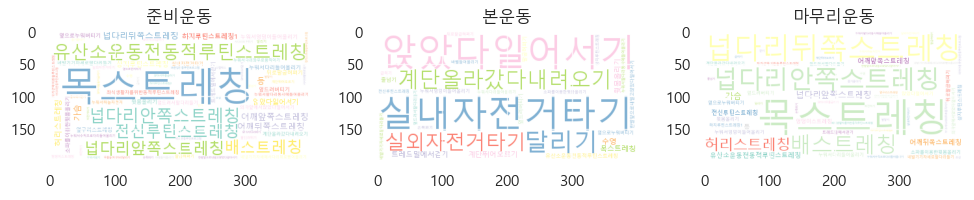

<Figure size 1000x500 with 0 Axes>

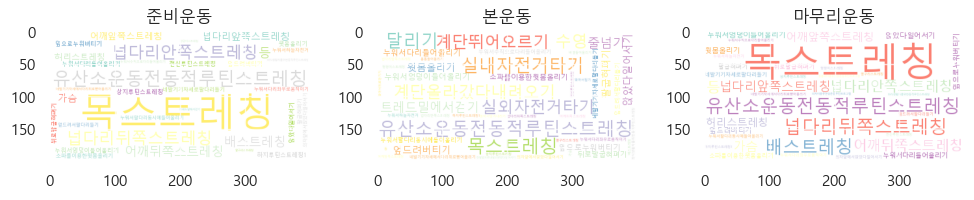

<Figure size 1000x500 with 0 Axes>

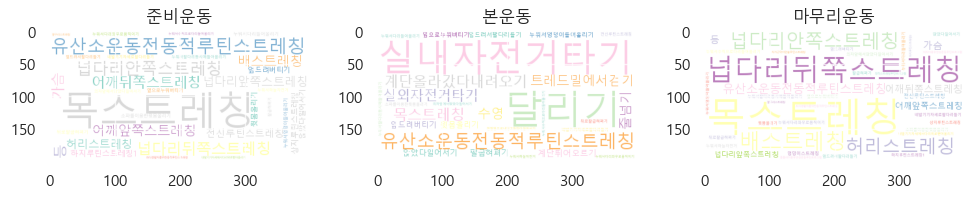

<Figure size 1000x500 with 0 Axes>

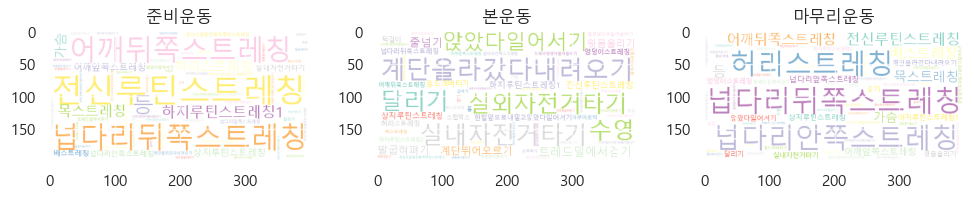

<Figure size 1000x500 with 0 Axes>

In [197]:

for i in range(1):
    sex=input('당신의 성별은? :')
    age=int(input('당신의 나이는(19-39) ? :'))
    word_cl=make_df_list(sex,age)
    print(word_cl)
    

# plotly rader chart

In [ ]:
import plotly.express as px
import pandas as pd
df = pd.DataFrame(dict(
    r=[1, 6, 2, 8, 3,9],
    theta=['심폐지구력','근력','근지구력',
           '유연성', '민첩성','순발력']))
fig = px.line_polar(df, r='r', theta='theta', line_close=True)
fig.update_traces(fill='toself')
fig.show()

In [ ]:
import plotly.graph_objects as go
import plotly.offline as pyo

categories = ['신장(cm)', '체중(kg)', '체지방율(%)', '허리둘레(cm)',
       'BMI(kg/㎡)']
categories = [*categories, categories[0]]

grade1 = [total_seoul['신장(cm)'].iloc[0], total_seoul['체중(kg)'].iloc[0], total_seoul['체지방율(%)'].iloc[0], total_seoul['허리둘레(cm)'].iloc[0], total_seoul['BMI(kg/㎡)'].iloc[0]]
grade2 = [total_seoul['신장(cm)'].iloc[10], total_seoul['체중(kg)'].iloc[10], total_seoul['체지방율(%)'].iloc[10], total_seoul['허리둘레(cm)'].iloc[10], total_seoul['BMI(kg/㎡)'].iloc[10]]
# grade3 = [83, 84, 95, 63, 75]
grade1 = [*grade1, grade1[0]]
grade2 = [*grade2, grade2[0]]
# grade3 = [*grade3, grade3[0]]

fig = go.Figure(
    data=[
        go.Scatterpolar(r=grade1, theta=categories, fill='toself', name='User1'),
        go.Scatterpolar(r=grade2, theta=categories, fill='toself', name='User2'),
        # go.Scatterpolar(r=grade3, theta=categories, fill='toself', name='Student3')
    ],
    layout=go.Layout(
        title=go.layout.Title(text='Grade'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

fig.show()

In [ ]:
import plotly.graph_objects as go

categories = ['심폐지구력','근력','근지구력',
           '유연성', '민첩성','순발력']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=[1, 5, 2, 2, 3],
      theta=categories,
      fill='toself',
      name='Product A'
))
fig.add_trace(go.Scatterpolar(
      r=[4, 3, 2.5, 1, 2],
      theta=categories,
      fill='toself',
      name='Product B'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 5]
    )),
  showlegend=False
)

fig.show()